# Present Value of Liabilities and Funding Ratio

the present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$PV(L) = \sum_{i=1}^{k}B(t_i)L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$

미래부채가치를 현재 가치로 환산하는 것.

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [2]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time t, given interest rate r
    """
    return (1+r)**(-t)

In [4]:
# 연 이율이 3%일 때, 10년 후 1달러의 현재 가치
discount(10, 0.03)

0.7440939148967249

In [5]:
0.7440939148967249*(1.03)**10

1.0

In [10]:
def pv(l, r):
    """
    Computes the present value of a sequence of liabilities
    l is indexed by the time, and values are the amounts of each liability
    returns the present value of the sequence
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

In [11]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [13]:
# 앞으로 갚아야 할 돈이 7달러
liabilities.sum()

7.0

In [15]:
# 갚아야 하는 돈의 현재 가치(금리가 3프로 일 때)
pv(liabilities, 0.03)

6.233320315080045

In [16]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of some assets given liabilities and interest rate
    """
    return assets/pv(liabilities, r)

In [18]:
# 부채 대비 자산의 비율
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

In [20]:
# 금리가 내려가면 부채는 고평가되고 현재 자산은 저평가되기 때문에 자산비율은 하락함
funding_ratio(5, liabilities, 0.01)

0.7427501569991474

In [23]:
funding_ratio(5, liabilities, 0.09)

1.001034854978827

In [22]:
import ipywidgets as widgets
from IPython.display import display

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print("{0:.2f}".format(fr*100))
    
controls = widgets.interactive(show_funding_ratio,
                              assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                               r = (0, 0.20, 0.01)
                              )
display(controls)

# 위에서 만든 liabilities 대비 자산비율

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

In [24]:
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

# CIR Model to simulate changes in Interest Rates and Liability Hedging

the Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek model to prevent negative interst rate:

$$ dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t $$

a는 회귀속도, b는 long-term 평균 이자율, $r_t$는 현재 이자율.

a의 속도로 평균 b로 수렴하는 이자율 $r_t$


## Short Rate vs Annualized

In general, if we compound every 1/N of a year (i.e. N times a year) we get:

$$ \left(1+\frac{r}{N}\right)^N $$

In [25]:
(1+1/365)**365

2.7145674820219727

N이 무한대로 가면 자연상수

r은 단기이율

R은 연이율

$$ r = ln(1+R) $$


In [29]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualized rate to a short rate
    """
    return np.log1p(r)

$$ dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t $$ 만들기

In [53]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

<AxesSubplot:>

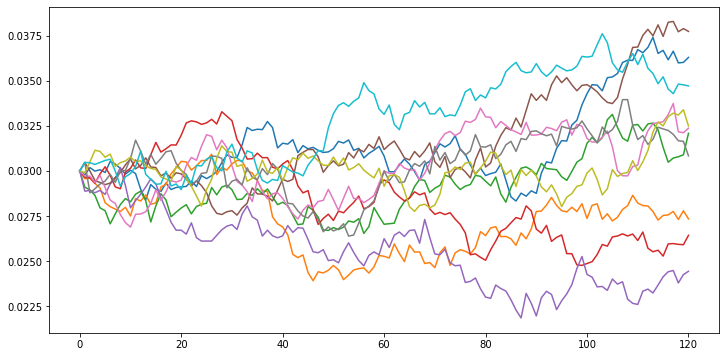

In [41]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,6), legend=False)

In [56]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,6))

controls = widgets.interactive(show_cir,
                              n_scenarios=widgets.IntSlider(min=1, max=100, step=1, value=30),
                               a=(0, 0.3, 0.01),
                               b=(0, 0.5, 0.01),
                               sigma=(0, 0.5, 0.01),
                               r_0=(0, 0.15, 0.01)
                              )

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.3, …

In [64]:
import math
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h+(h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices

In [66]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,6))

controls = widgets.interactive(show_cir_prices,
                              n_scenarios=widgets.IntSlider(min=1, max=100, step=1, value=30),
                               a=(0, 1, 0.1),
                               b=(0, 0.5, 0.01),
                               sigma=(0, 0.5, 0.01),
                               r_0=(0, 0.15, 0.01)
                              )

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [67]:
a_0 = 0.75
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()


<AxesSubplot:>

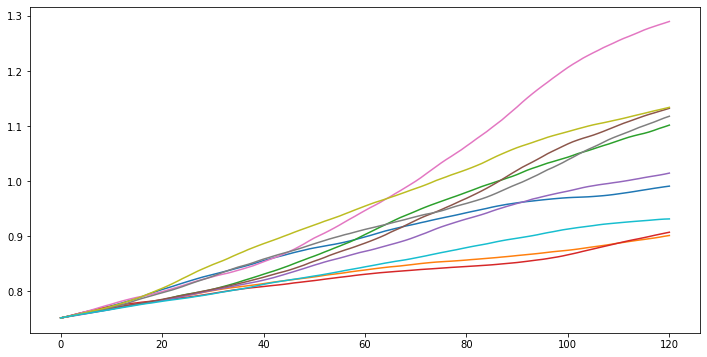

In [71]:
av_cash.plot(legend=False, figsize=(12,6))

<AxesSubplot:>

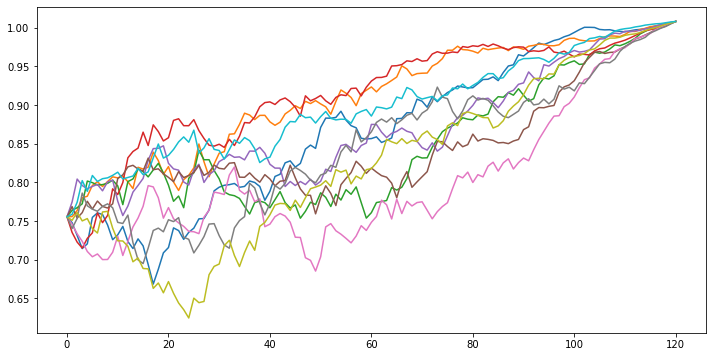

In [73]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

<AxesSubplot:title={'center':'REturns of Funding Ratio with Cash (10 scenarios)'}>

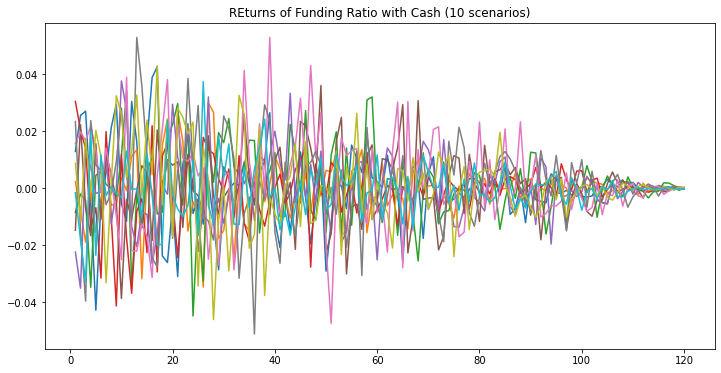

In [75]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12, 6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash (10 scenarios)'}>

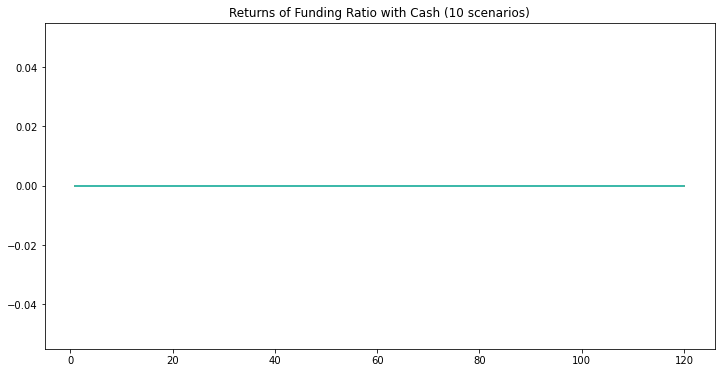

In [76]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12, 6))

In [81]:
a_0 = 0.5
rates, bond_prices = cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10000)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:label='19b7a179-b3e6-4198-b551-8217a98f8827'>

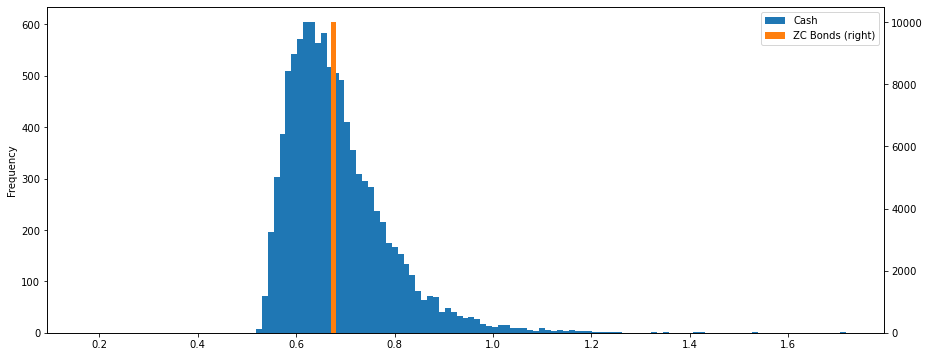

In [82]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label='Cash', figsize=(15,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label='ZC Bonds', bins=100, legend=True, secondary_y=True)

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

# GHP Construction with Duration Mathching

In [4]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [7]:
erk.bond_price(20, 1000, 0.05, 2, 0.04)

1136.7773962036904

In [8]:
erk.bond_price(20, 1000, 0.05, 2, 0.05)

1000.0000000000023

In [9]:
erk.bond_price(20, 1000, 0.05, 2, 0.02)

1492.520291709342

In [10]:
rates = np.linspace(0.01, 0.10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [12]:
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

<AxesSubplot:title={'center':'Price of 10y bond with diff interest rates'}>

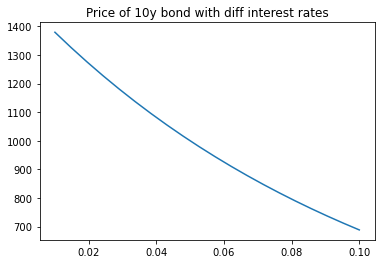

In [15]:
pd.DataFrame(data=prices, index=rates).plot(legend=False, title="Price of 10y bond with diff interest rates")

In [16]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)

In [17]:
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [18]:
discounts = erk.discount(cf.index, 0.03)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [20]:
dcf = discounts*cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [23]:
weights  = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [26]:
(cf.index*weights).sum()

5.579707187194534

In [25]:
cf.index

Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')

In [27]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)

5.579707187194534

## Duration Matching

In [4]:
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [2]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1), 0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1), 0.04)


In [3]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

In our case, the fraction in the short duration aeest $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l - d_t}{d_l - d_s} $$

In [6]:
short_bond = erk.bond_cash_flows(10, 1000, 0.05, 1)
long_bond = erk.bond_cash_flows(20, 1000, 0.05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [9]:
p_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)
p_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)
a_0 = 130000
p_flows = pd.concat([a_0*w_s*short_bond/p_short, a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows, 0.04)

10.960799385088393

In [12]:
cfr = erk.funding_ratio(p_flows, liabilities, 0.04)
cfr

0.9998760012192478

<AxesSubplot:title={'center':'Funding Ratios with changes in Interest Rats'}>

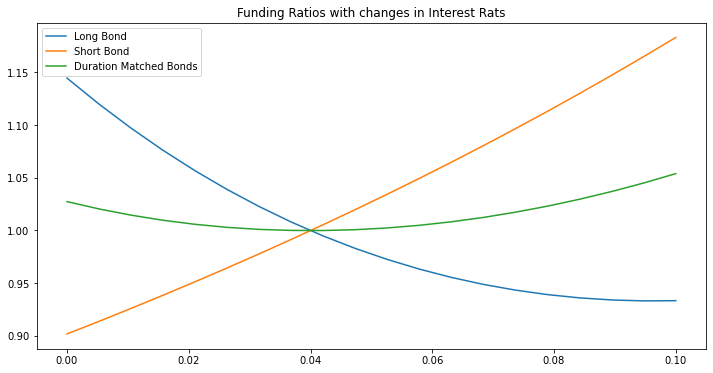

In [16]:
rates = np.linspace(0, 0.1, 20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short

fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond": [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds": [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title="Funding Ratios with changes in Interest Rats", figsize=(12,6))